In [43]:
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np
import ntpath
import os
import xml.etree.ElementTree as ET

In [44]:
pathProject = r'C:\Users\AdminAsus\PycharmProjects\MaisRecognition'
size = 1280
stride = 320

In [49]:
def slice_img(img, size, stride):
    img2 = img.copy()
    for wid in range(0, img2.shape[0], stride):
         for height in range(0, img2.shape[1], stride):
            sliced_img = img2[wid:wid + size, height:height + size]
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(sliced_img, cv2.COLOR_BGR2RGB))

    resized_image = cv2.resize(img, (size, size))
    print(resized_image.shape)

    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    
def MakeXMLFile(path: str, xmins, xmaxs, ymins, ymaxs, classnames, number, subdirectory_name = "SlicedImages"):

    margin_lvl = 0
    file_path, filename = ntpath.split(path)
    _, folder = ntpath.split(file_path)
    img = cv2.imread(path)
    height, width, depth = size, size, 3 #img.shape
    XMLfilename = filename.split('.')[0]
    JPGFileName = XMLfilename + str(number) + '.jpg'
    XMLfilename = os.path.join(file_path,subdirectory_name,XMLfilename + str(number) + '.xml')

    with open(XMLfilename, 'w') as f:
        f.write('<annotation>\n')
        margin_lvl += 1
        f.write('\t'*margin_lvl + f'<folder>{folder}</folder>\n')
        f.write('\t'*margin_lvl + f'<filename>{JPGFileName}</filename>\n')
        f.write('\t'*margin_lvl + f'<path>{path}</path>\n')
        f.write('\t'*margin_lvl + f'<source>\n')
        margin_lvl += 1 
        f.write('\t'*margin_lvl + '<database>Unknown</database>\n')
        margin_lvl -= 1
        f.write('\t'*margin_lvl + f'</source>\n')
        f.write('\t'*margin_lvl + '<size>\n')
        margin_lvl += 1
        f.write('\t'*margin_lvl + f'<width>{width}</width>\n')
        f.write('\t'*margin_lvl + f'<height>{height}</height>\n')
        f.write('\t'*margin_lvl + f'<depth>{depth}</depth>\n')
        margin_lvl -= 1
        f.write('\t'*margin_lvl + '</size>\n')
        f.write('\t'*margin_lvl + '<segmented>0</segmented>\n')
        
        for xmin, xmax, ymin, ymax, class_name in zip(xmins, xmaxs, ymins, ymaxs, classnames):
#             xmin, ymin, xmax, ymax = contour[0], contour[1], contour[0] + contour[2], contour[1] + contour[3]
            f.write('\t'*margin_lvl + '<object>\n')
            margin_lvl += 1
            f.write('\t'*margin_lvl + f'<name>{class_name}</name>\n')
            f.write('\t'*margin_lvl + f'<pose>Unspecified</pose>\n')
            f.write('\t'*margin_lvl + f'<truncated>0</truncated>\n')
            f.write('\t'*margin_lvl + f'<difficult>0</difficult>\n')
            f.write('\t'*margin_lvl + '<bndbox>\n')
            margin_lvl += 1
            f.write('\t'*margin_lvl + f'<xmin>{max(0,xmin)}</xmin>\n')
            f.write('\t'*margin_lvl + f'<ymin>{max(0,ymin)}</ymin>\n')
            f.write('\t'*margin_lvl + f'<xmax>{min(xmax, size)}</xmax>\n')
            f.write('\t'*margin_lvl + f'<ymax>{min(ymax, size)}</ymax>\n')
            margin_lvl -= 1
            f.write('\t'*margin_lvl + '</bndbox>\n')
            margin_lvl -= 1
            f.write('\t'*margin_lvl + '</object>\n')
        
        f.write('</annotation>')

In [46]:
img = cv2.imread(os.path.join(pathProject, 'resources', 'IMG_4330_wb.jpg'))

In [50]:
from time import sleep
# tree = ET.parse('D:/projects/CornClassifier/resources/IMG_4330_wb.xml')
# root = tree.getroot()
# img2 = img.copy()
img_size = (size, size)
bound_box_margin = 2

label_classname = {
    'mais' : 0,
    'dill' : 1,
    'buckwheat': 2,
    'other': 3
}
label_to_classname = {v: k for k, v in label_classname.items()}

for i in range(4310, 4331):
    img = cv2.imread(os.path.join(pathProject, 'resources',f'IMG_{i}_wb.jpg'))
    tree = ET.parse(os.path.join(pathProject, 'resources',f'IMG_{i}_wb.xml'))
    root = tree.getroot()
    img2 = img.copy()

    bounds = np.array([(int(xmin.text), int(xmax.text), int(ymin.text), int(ymax.text), label_classname[name.text]) for xmin, xmax, ymin, ymax, name in zip(root.findall('.//xmin'),\
                                        root.findall('.//xmax'), root.findall('.//ymin'), root.findall('.//ymax'), root.findall('.//name'))])


    count = 0
    path = os.path.join(pathProject, 'resources',f'IMG_{i}_wb.jpg')
    for wid in range(0, img.shape[0] - size, stride):
        for hei in range(0, img2.shape[1] - size, stride):
            if img2[hei: hei + size, wid:wid + size].shape == (size, size, 3):

                tempPath = os.path.join(pathProject, 'SlicedImages1280',f'IMG_{i}_wb{count}.jpg')
                print(wid, hei, img2[hei: hei + size, wid:wid + size].shape, tempPath)
                sliced_bounds = bounds[(bounds[:, 0] < wid + size) & (bounds[:, 0] > wid) & (bounds[:, 2] < hei + size) & (bounds[:, 2] > hei)]
                classname = list(map(label_to_classname.get, sliced_bounds[:, 4]))
                xmins = sliced_bounds[:, 0]
                xmaxs = sliced_bounds[:, 1]
                ymins = sliced_bounds[:, 2]
                ymaxs = sliced_bounds[:, 3]
                MakeXMLFile(os.path.join(pathProject, f'IMG_{i}_wb.jpg'), xmins - wid - bound_box_margin, xmaxs - wid + bound_box_margin, ymins - hei - bound_box_margin, ymaxs - hei + bound_box_margin, classname, count, subdirectory_name= 'SlicedImages1280')
        #         for xmin, xmax, ymin, ymax, classname in sliced_bounds:
        #             cv2.rectangle(img2, (xmin - bound_box_margin, ymin - bound_box_margin), (xmax + bound_box_margin, ymax + bound_box_margin), (255, 0, 0), 5)
    #             plt.figure(figsize=(10, 7))
    #             plt.imshow(cv2.cvtColor(img2[hei: hei + 640, wid:wid + 640], cv2.COLOR_BGR2RGB))
                cv2.imwrite(tempPath, img2[hei: hei + size, wid:wid + size])
                count += 1
    break


0 0 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb0.jpg
0 320 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb1.jpg
0 640 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb2.jpg
0 960 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb3.jpg
0 1280 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb4.jpg
320 0 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb5.jpg
320 320 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb6.jpg
320 640 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb7.jpg
320 960 (1280, 1280, 3) C:\Users\AdminAsus\PycharmProjects\MaisRecognition\SlicedImages1280\IMG_4310_wb8.jpg
320 1280 (1280, 1280, 3) C:\User

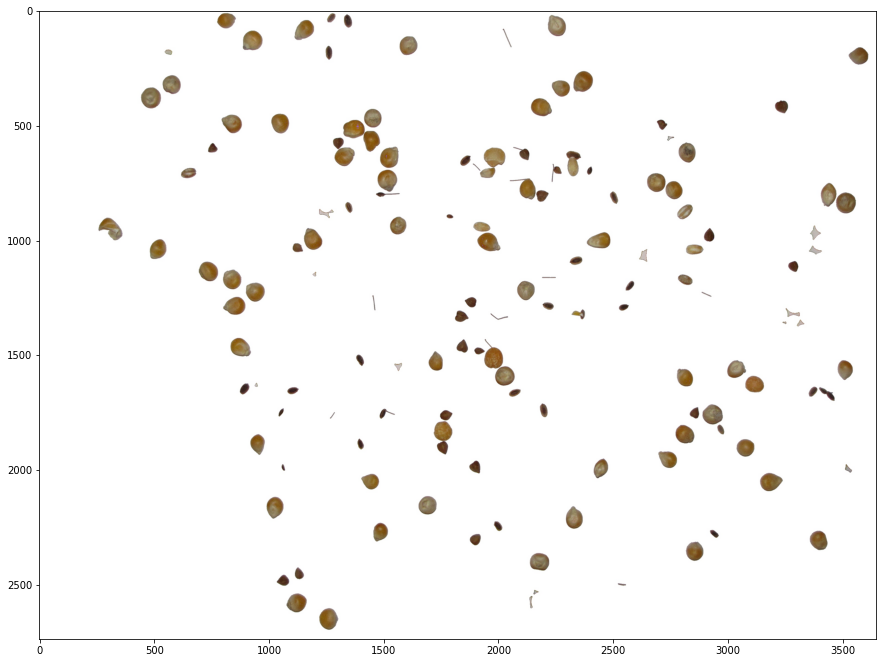

In [48]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [18]:
img_size

(1280, 1280)

<ipython-input-21-a063adf6642d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 7))


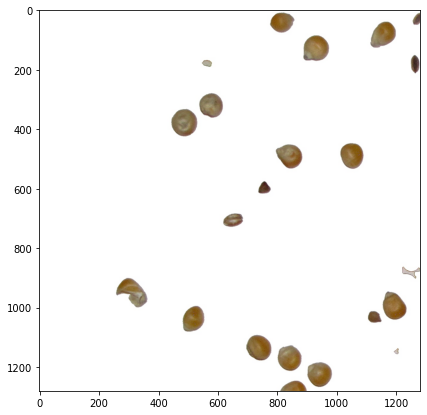

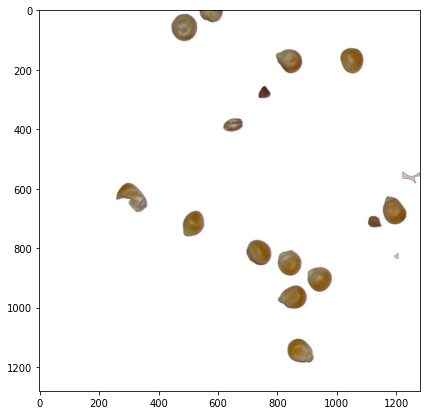

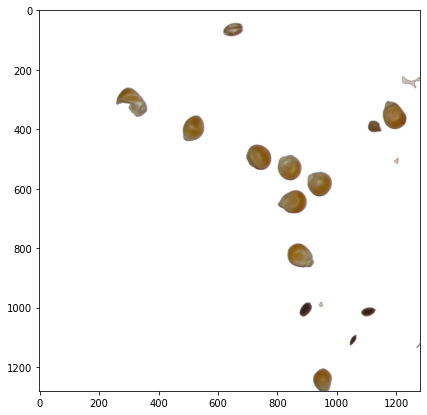

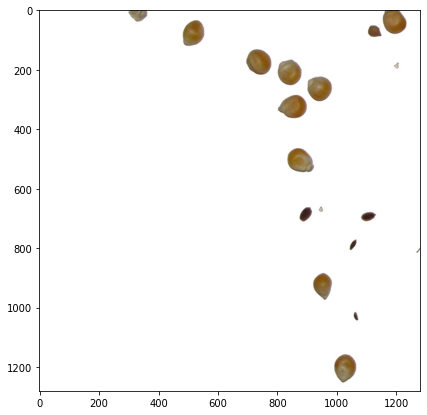

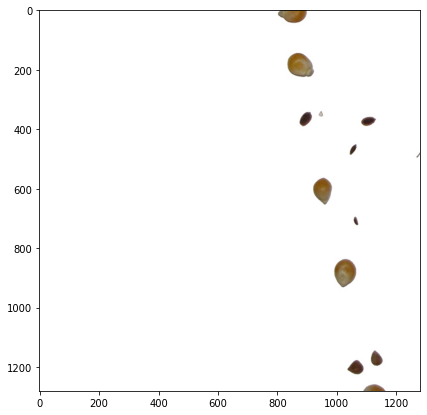

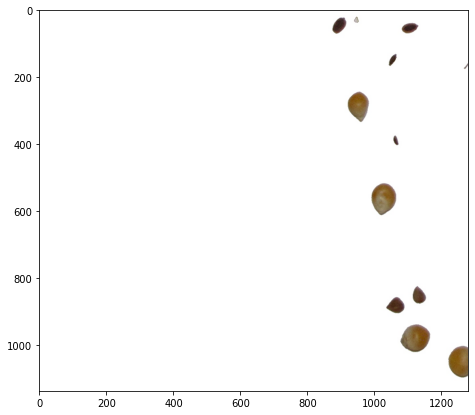

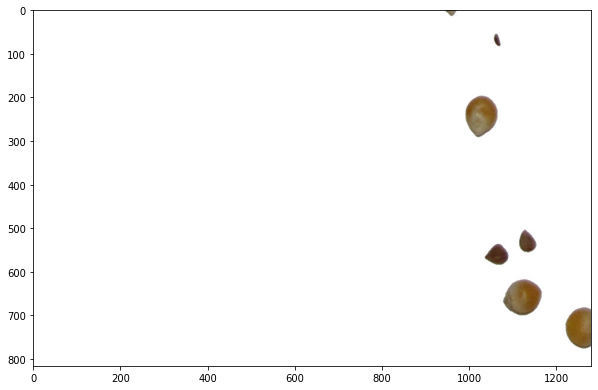

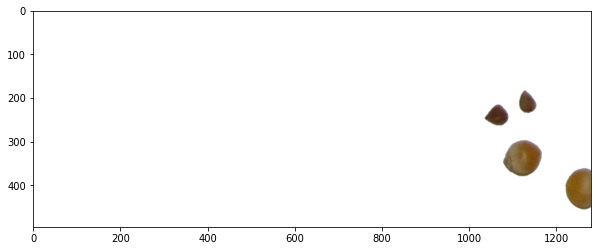

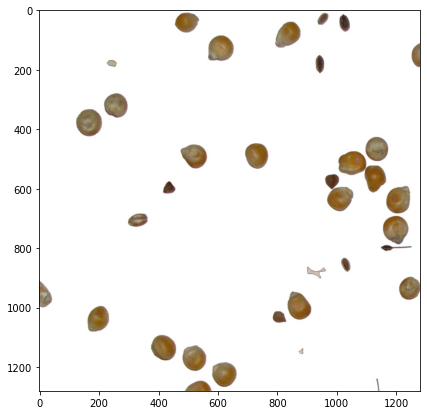

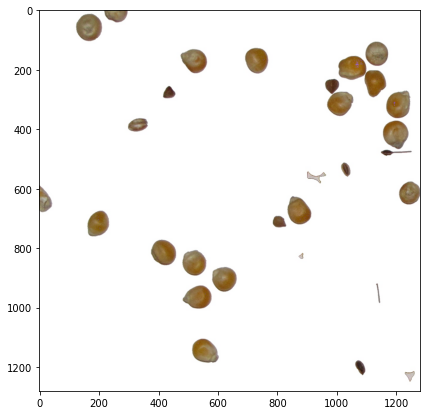

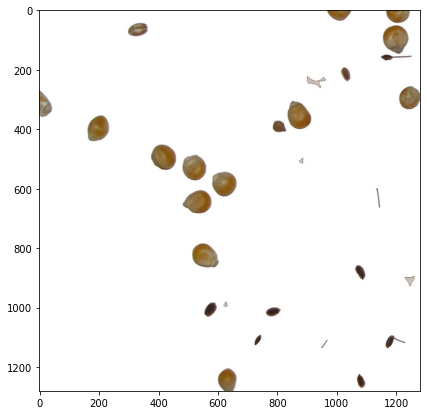

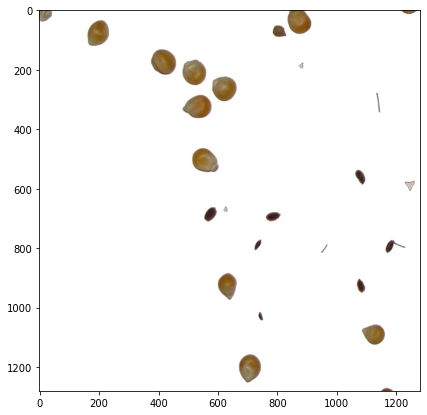

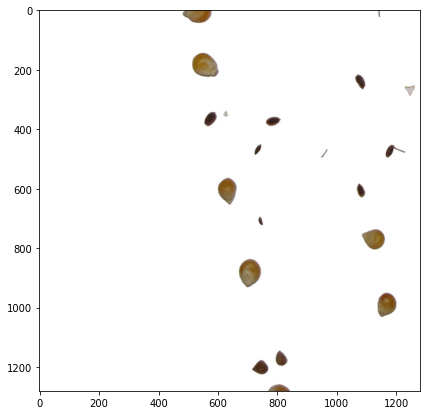

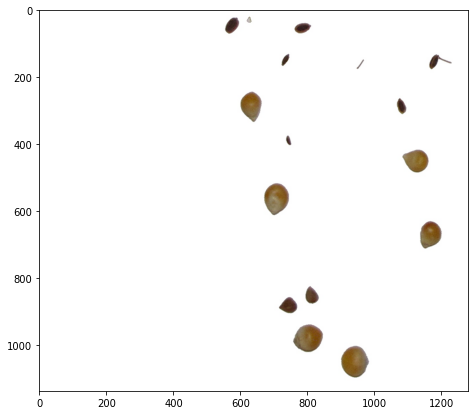

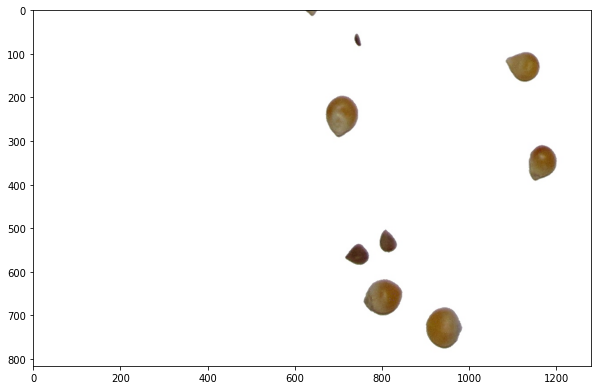

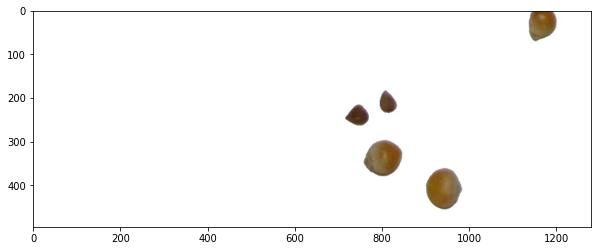

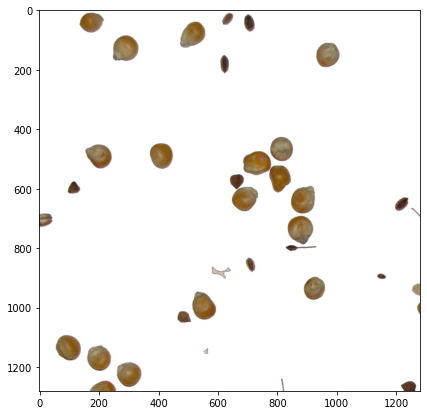

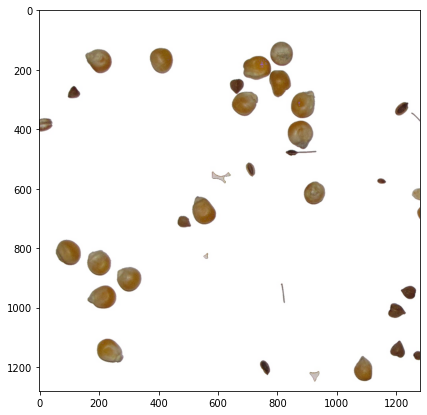

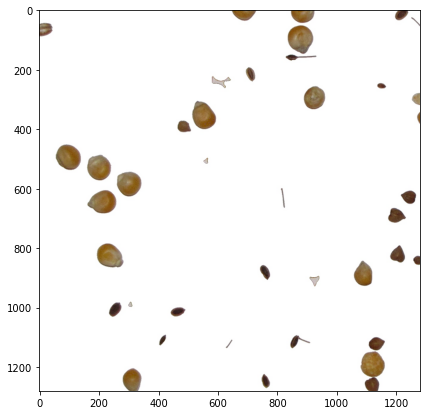

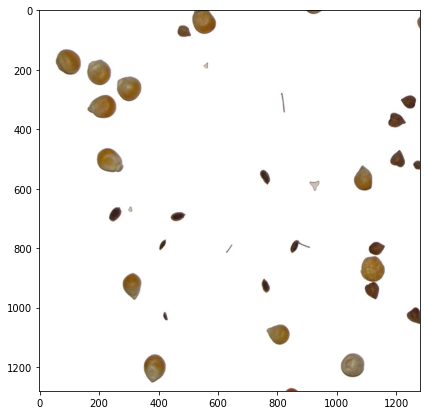

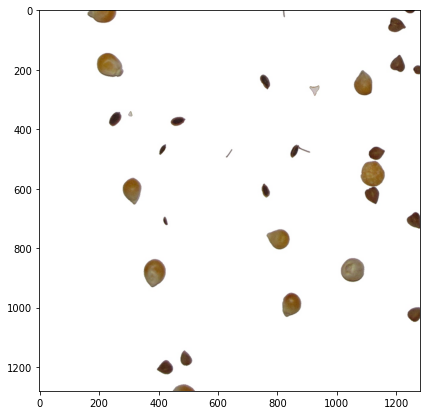

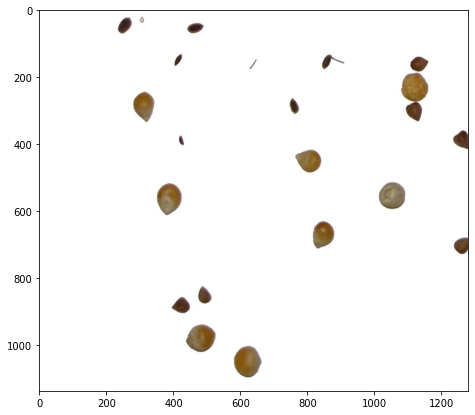

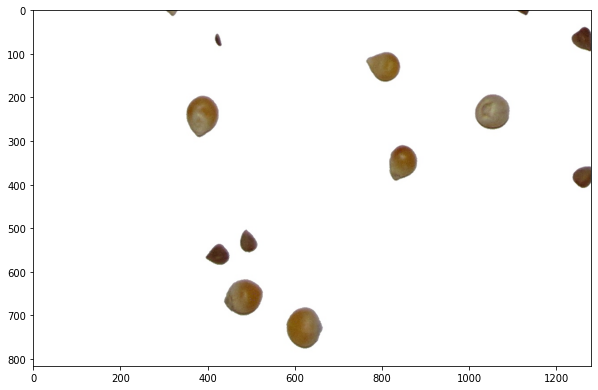

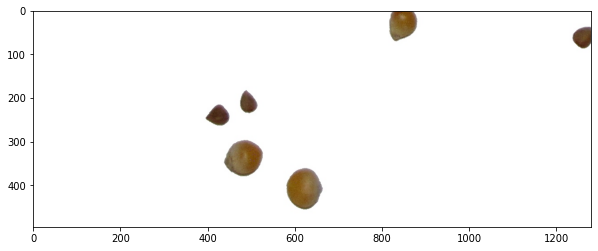

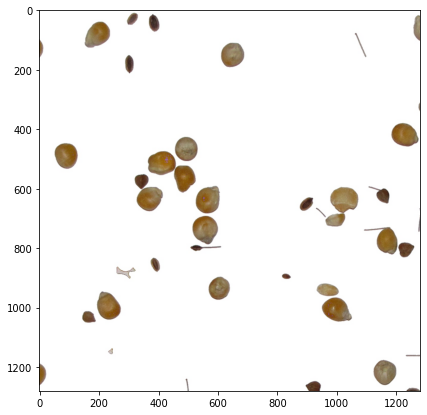

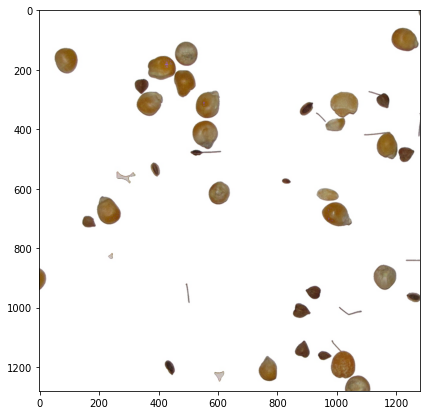

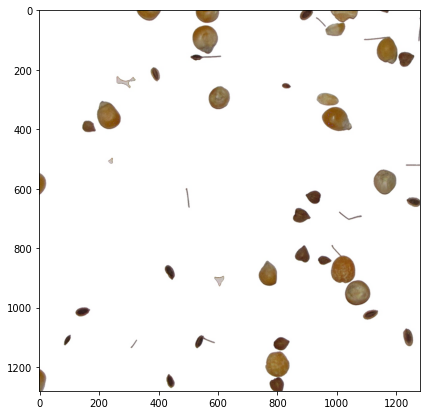

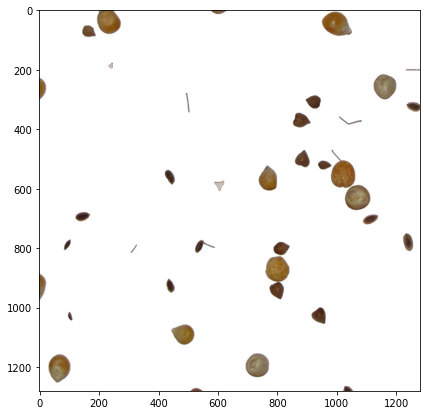

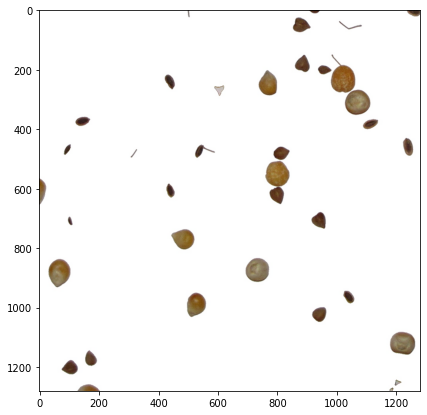

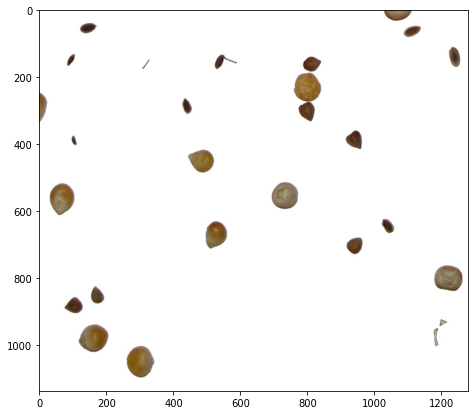

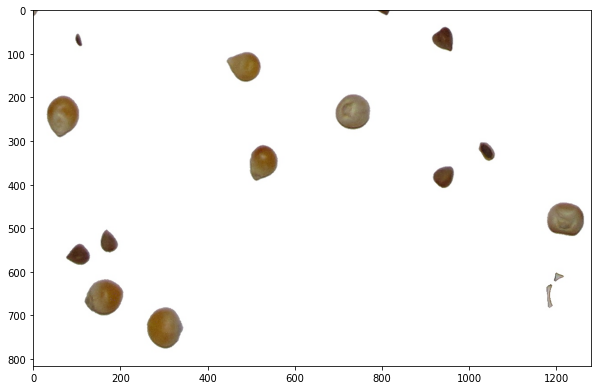

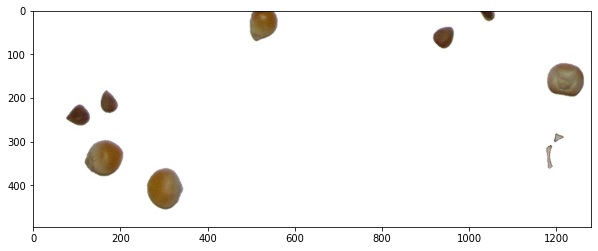

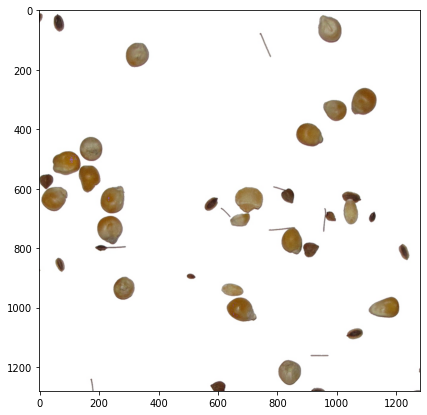

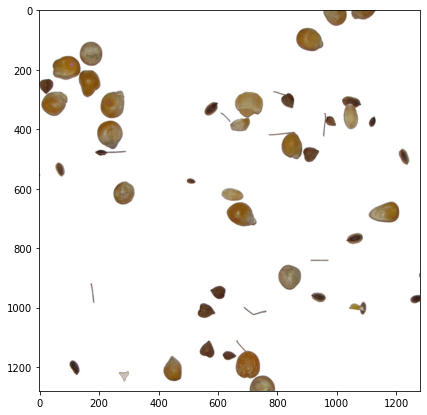

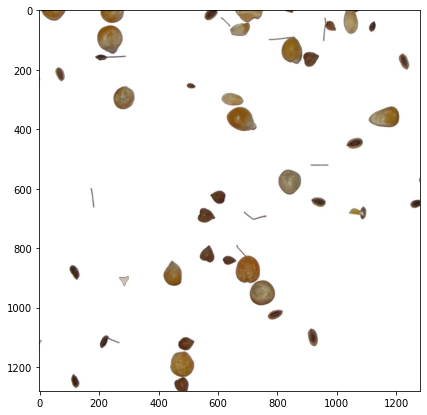

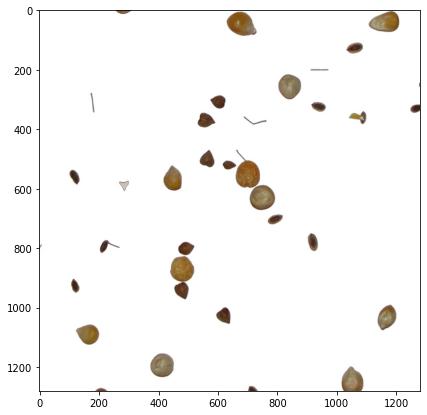

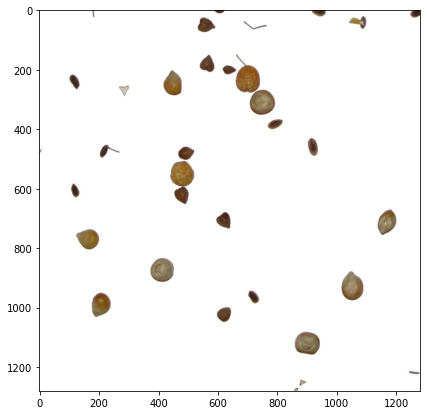

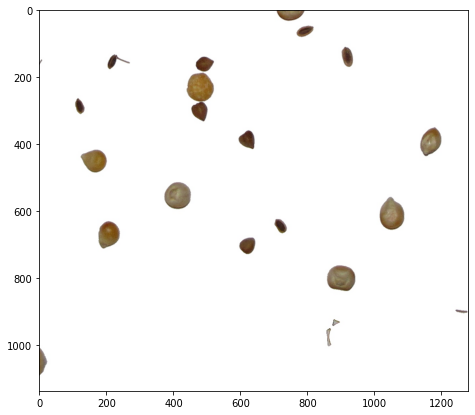

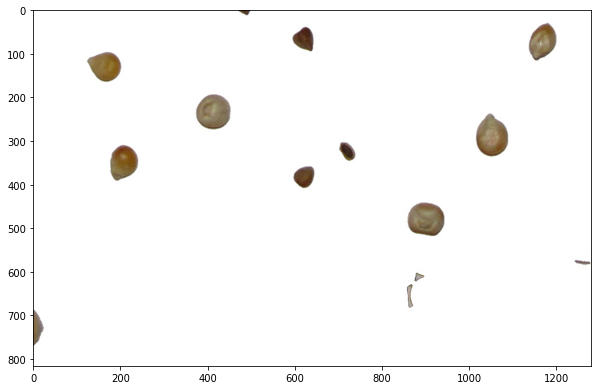

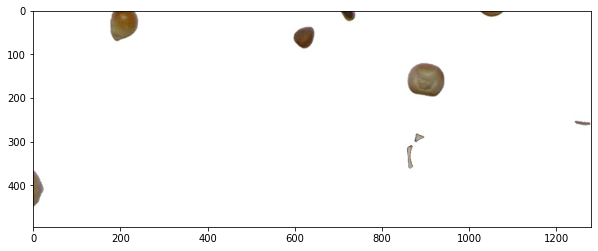

In [21]:
for wid in range(0, img.shape[0]- size, stride):
    for hei in range(0, img2.shape[1] - size, stride):
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img2[ hei: hei + size, wid:wid + size], cv2.COLOR_BGR2RGB))